In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Reshape, Activation, Dropout, Input, BatchNormalization, Conv1D, SeparableConv1D
from keras.layers import Conv2D, Flatten, AveragePooling1D, AveragePooling2D, Merge, Concatenate, Embedding, LSTM
from keras.layers import add, concatenate, MaxPooling1D
from keras.optimizers import Adam

C:\Users\Lemen\Anaconda3\envs\Numerai_101\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
DATASETS_DIR = "./datasets"

def fetch_df(dataset):
    if dataset == 'training':
        path = DATASETS_DIR + "/numerai_training_data.csv"
    elif dataset == 'tournament':
        path = DATASETS_DIR + "/numerai_tournament_data.csv"
    return pd.read_csv(path)

def targets(df):
    """Returns only the columns we use as features"""
    return df.drop(['id', 'era', 'data_type', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10',
               'feature11', 'feature12', 'feature13', 'feature14', 'feature15', 'feature16', 'feature17', 'feature18', 'feature19',
               'feature20', 'feature21', 'feature22', 'feature23', 'feature24', 'feature25', 'feature26', 'feature27', 'feature28',
               'feature29', 'feature30', 'feature31', 'feature32', 'feature33', 'feature34', 'feature35', 'feature36', 'feature37',
               'feature38', 'feature39', 'feature40', 'feature41', 'feature42', 'feature43', 'feature44', 'feature45', 'feature46',
               'feature47', 'feature48', 'feature49', 'feature50'], axis=1).values

def features(df):
    """Returns only the columns we use as targets"""
    return df.drop(['id', 'era', 'data_type', 'target_bernie', 'target_charles', 'target_elizabeth', 
                    'target_jordan', 'target_ken'], axis=1).values

def training_set():
    df = fetch_df('training')
    eras = df["era"].map(lambda x: int(x[3:])).values
    X = features(df)
    y = targets(df)
    return eras, X, y

def tournament_set(data_type=None):
    df = fetch_df('tournament')
    if data_type is not None:
        df = df[df['data_type'] == data_type]
    ids = df['id'].values
    X = features(df)
    y = targets(df)
    return ids, X, y

def test_set():
    return tournament_set('test')

def validation_set():
    return tournament_set('validation')

def live_set():
    return tournament_set('live')

In [23]:
_, X, Y = training_set()
val_ids, X_val, Y_val = validation_set()

In [24]:
def base64(block_input):
    base_input = Input(shape=block_input)
    dense14 = Dense(14)(base_input)
    concat1 = concatenate([base_input,dense14])
    return base_input, concat1

In [25]:
layer1in, layer1out1 = base64((50,))

In [26]:
def block01(block_input):
    
    reshape1 = Reshape((2**4,2**2),input_shape=(2**6,))(block_input) 
    conv1 = Conv1D(2**2, 1+2**1, padding='same', activation='relu')(reshape1)
    flatten01 = Flatten()(conv1)  
    
    dense1 = Dense(2**6, activation='relu')(flatten01)
      
    dropout1 = Dropout(1/2**2)(dense1)
    batchnorm1 = BatchNormalization(axis=-1)(dropout1)
    
    return batchnorm1

In [28]:
layers = []
layers.append(block01(layer1out1))

for i in range(0, 5):
    layer = block01(layers[i])
    layers.append(layer)
finallayer = Dense(5, activation='sigmoid')(layers[-1])

In [29]:
model = Model(inputs=layer1in, outputs = finallayer)

In [30]:
#model.summary()

In [31]:
opt = Adam(lr=0.0003)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(X, Y, batch_size = 2**10, epochs=70, initial_epoch=0, validation_data=(X_val,Y_val))

In [ ]:
loss, acc = model.evaluate(X, Y)
print("Accuracy = ", acc)
print("Logloss = ", loss)

In [ ]:
val_ids, X_val, Y_val = validation_set()
loss_val, acc_val = model.evaluate(X_val, Y_val)
print("Accuracy = ", acc_val)
print("Logloss = ", loss_val)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


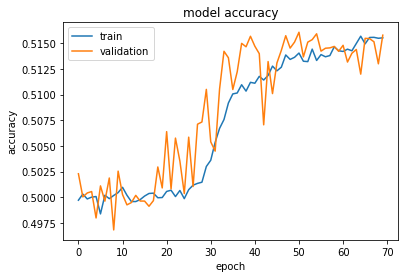

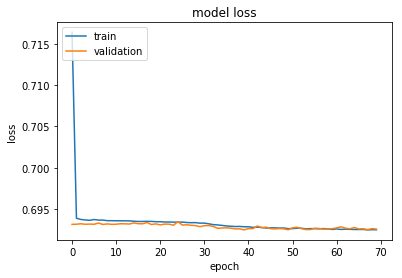

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
tournament_ids, Xtournament, _ = tournament_set()
ytournament = model.predict(Xtournament)

In [39]:
ytournament[0][2]
#ytournament = ytournament[:,0]

0.49649447

In [ ]:
predictions_df = pd.DataFrame(data={'id':tournament_ids, 'probability':ytournament})
predictions_df.to_csv('predictions.csv', index=False)
predictions_df.head()
print(predictions_df.shape)

In [100]:
bernie = np.zeros((ytournament.shape[0]))
charles = np.zeros((ytournament.shape[0]))
elizabeth = np.zeros((ytournament.shape[0]))
jordan = np.zeros((ytournament.shape[0]))
ken = np.zeros((ytournament.shape[0]))
for i in range(len(ytournament)):
    bernie[i] = ytournament[i][0]
    charles[i] = ytournament[i][1]
    elizabeth[i] = ytournament[i][2]
    jordan[i] = ytournament[i][3]
    ken[i] = ytournament[i][4]

In [101]:
list = []
list.append(bernie)
list.append(charles)
list.append(elizabeth)
list.append(jordan)
list.append(ken)

In [ ]:
targets = ('target_bernie', 'target_charles', 'target_elizabeth', 'target_jordan', 'target_ken')
names = ('bernie', 'charles', 'elizabeth', 'jordan', 'ken')
for i in range(ytournament.shape[1]):
    predictions_df = pd.DataFrame(data={'id':tournament_ids, 'probability_'+names[i]:list[i]})
    predictions_df.to_csv(targets[i] + '_predictions.csv', index=False)
    predictions_df.head()
    print(predictions_df.shape)